THIS IS THE SAME AS 2019 80/20 BUT WITH 70/30 SPLIT

In [ ]:
# Core libraries
import os
import hashlib
import numpy as np
import pandas as pd

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

# Google
from google.colab import drive

# Keras
from keras.models import Sequential
from keras.layers import (
    Dense, Dropout, BatchNormalization, Flatten,
    Conv1D, MaxPooling1D, GRU, LSTM, Embedding
)
from keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
drive.mount('/content/drive')

base_path = "/content/drive/My Drive/Final Year/"

folders = ["01-12", "03-11"]

files_by_folder = {
    "01-12": [
        "TFTP.csv", "DrDoS_LDAP.csv", "DrDoS_MSSQL.csv", "DrDoS_NetBIOS.csv",
        "DrDoS_NTP.csv", "DrDoS_SNMP.csv", "DrDoS_SSDP.csv", "DrDoS_UDP.csv",
        "Syn.csv", "DrDoS_DNS.csv", "UDPLag.csv"
    ],
    "03-11": [
        "LDAP.csv", "MSSQL.csv", "NetBIOS.csv", "PortMap.csv",
        "Syn.csv", "UDP.csv", "UDPLag.csv"
    ]
}

dtype_spec = {85: "str", 21: "str"}  # Force problematic columns to strings

def load_huge_file(path):
    chunk_list_ok = []
    chunk_list_ddos = []

    for chunk in pd.read_csv(path, chunksize=500000, dtype=dtype_spec, low_memory=False):
        chunk.columns = chunk.columns.str.strip()  # Fix column names
        is_benign = chunk['Label'] == 'BENIGN'
        flows_ok = chunk[is_benign]
        flows_ddos_full = chunk[~is_benign]

        if len(flows_ok) * 5 < len(flows_ddos_full):
            size_downsample = len(flows_ok) * 5
            flows_ddos_reduced = resample(flows_ddos_full, replace=False, n_samples=size_downsample, random_state=27)
        else:
            flows_ddos_reduced = flows_ddos_full

        chunk_list_ok.append(flows_ok)
        chunk_list_ddos.append(flows_ddos_reduced)

    return pd.concat(chunk_list_ok, ignore_index=True), pd.concat(chunk_list_ddos, ignore_index=True)

def load_file(path):
    data = pd.read_csv(path, sep=',', dtype=dtype_spec, low_memory=False)  # Load all at once for smaller files
    data.columns = data.columns.str.strip()  # Fix column names

    is_benign = data['Label'] == 'BENIGN'
    flows_ok = data[is_benign]
    flows_ddos_full = data[~is_benign]

    size_downsample = len(flows_ok) * 5  # Adjust factor as needed

    if size_downsample < len(flows_ddos_full):
        flows_ddos_reduced = resample(flows_ddos_full, replace=False, n_samples=size_downsample, random_state=27)
    else:
        flows_ddos_reduced = flows_ddos_full

    return flows_ok, flows_ddos_reduced

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    output_path = os.path.join(folder_path, "export_dataframe.csv")

    first_file = files_by_folder[folder][0]
    first_file_path = os.path.join(folder_path, first_file)

    if os.path.exists(first_file_path):
        flows_ok, flows_ddos = load_huge_file(first_file_path)
        print(f"Loaded: {first_file}")
        pd.concat([flows_ok, flows_ddos], ignore_index=True).to_csv(output_path, index=False)
    else:
        print(f"Missing file: {first_file}")
        continue

    for file in files_by_folder[folder][1:]:
        file_path = os.path.join(folder_path, file)

        if os.path.exists(file_path):
            a, b = load_file(file_path)
            new_data = pd.concat([a, b], ignore_index=True)
            new_data.to_csv(output_path, mode='a', index=False, header=False)  # Append without reloading entire dataset
            print(f"Appended: {file}")
        else:
            print(f"Skipping missing file: {file}")

    print(f"Final exported file: {output_path}")

print("All files processed successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: TFTP.csv
Appended: DrDoS_LDAP.csv
Appended: DrDoS_MSSQL.csv
Appended: DrDoS_NetBIOS.csv
Appended: DrDoS_NTP.csv
Appended: DrDoS_SNMP.csv
Appended: DrDoS_SSDP.csv
Appended: DrDoS_UDP.csv
Appended: Syn.csv
Appended: DrDoS_DNS.csv
Appended: UDPLag.csv
Final exported file: /content/drive/My Drive/Final Year/01-12/export_dataframe.csv
Loaded: LDAP.csv
Appended: MSSQL.csv
Appended: NetBIOS.csv
Skipping missing file: PortMap.csv
Appended: Syn.csv
Appended: UDP.csv
Appended: UDPLag.csv
Final exported file: /content/drive/My Drive/Final Year/03-11/export_dataframe.csv
All files processed successfully!


In [ ]:
import pandas as pd
import numpy as np
import hashlib
import os
from google.colab import drive
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

base_path = "/content/drive/My Drive/Final Year/01-12/"
input_file = os.path.join(base_path, "export_dataframe.csv")
train_output_file = os.path.join(base_path, "export_dataframe_proc.csv")
test_output_file = os.path.join(base_path, "export_tests.csv")  # ✅ New Test File

dtype_spec = {85: str}  # Ensure Column 85 is treated as a string
samples = pd.read_csv(input_file, sep=',', dtype=dtype_spec, low_memory=False)

samples.columns = samples.columns.str.strip()

def string2numeric_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16)

samples.replace(['Infinity', np.inf], 0, inplace=True)
samples['Flow Packets/s'] = pd.to_numeric(samples['Flow Packets/s'], errors='coerce').fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'], errors='coerce').fillna(0)

attack_labels = [
    'DrDoS_DNS', 'DrDoS_LDAP', 'DrDoS_MSSQL', 'DrDoS_NTP', 'DrDoS_NetBIOS',
    'DrDoS_SNMP', 'DrDoS_SSDP', 'DrDoS_UDP', 'Syn', 'TFTP', 'UDP-lag', 'WebDDoS'
]
samples['Label'] = samples['Label'].apply(lambda x: 1 if x in attack_labels else 0)

if 'Timestamp' in samples.columns:
    samples['Timestamp'] = samples['Timestamp'].fillna('')  # Fill NaN with empty string
    time_data = samples['Timestamp'].str.split(' ', n=1, expand=True)

    if time_data.shape[1] > 1:  # Ensure there are two parts
        time_data.columns = ['day', 'time']
        time_data['time'] = time_data['time'].str.split('.', n=1, expand=True)[0]  # Extract HH:MM:SS
        samples['Timestamp'] = time_data['time'].apply(string2numeric_hash)

drop_cols = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
samples.drop(columns=drop_cols, errors='ignore', inplace=True)

train_data, test_data = train_test_split(samples, test_size=0.3, random_state=42, stratify=samples['Label'])

train_data.to_csv(train_output_file, index=False)
test_data.to_csv(test_output_file, index=False)  # ✅ Now we have a test dataset!

print('Training data saved at:', train_output_file)
print('Test data saved at:', test_output_file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data saved at: /content/drive/My Drive/Final Year/01-12/export_dataframe_proc.csv
Test data saved at: /content/drive/My Drive/Final Year/01-12/export_tests.csv


In [ ]:
import os

base_path = "/content/drive/My Drive/Final Year/01-12/"
input_file = os.path.join(base_path, "export_tests.csv")

if os.path.exists(input_file):
    print("File exists:", input_file)
else:
    print("File NOT FOUND:", input_file)


File exists: /content/drive/My Drive/Final Year/01-12/export_tests.csv


In [ ]:
import pandas as pd
import numpy as np
import hashlib
import os
from google.colab import drive

drive.mount('/content/drive')

base_path = "/content/drive/My Drive/Final Year/01-12/"
input_file = os.path.join(base_path, "export_tests.csv")
output_file = os.path.join(base_path, "export_tests_proc.csv")

dtype_spec = {85: str}  # Ensure Column 85 is treated as a string
tests = pd.read_csv(input_file, sep=',', dtype=dtype_spec, low_memory=False)

tests.columns = tests.columns.str.strip()

def string2numeric_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16)

tests.replace(['Infinity', np.inf], 0, inplace=True)
tests['Flow Packets/s'] = pd.to_numeric(tests['Flow Packets/s'], errors='coerce').fillna(0)
tests['Flow Bytes/s'] = pd.to_numeric(tests['Flow Bytes/s'], errors='coerce').fillna(0)

attack_labels = ['LDAP', 'NetBIOS', 'MSSQL', 'Portmap', 'Syn']
tests['Label'] = tests['Label'].apply(lambda x: 1 if x in attack_labels else 0)

if 'Timestamp' in tests.columns:
    tests['Timestamp'] = tests['Timestamp'].astype(str).fillna('')  # Convert to string, fill NaN
    time_data = tests['Timestamp'].str.split(' ', n=1, expand=True)

    if time_data.shape[1] > 1:  # Ensure there are two parts
        time_data.columns = ['day', 'time']
        time_data['time'] = time_data['time'].str.split('.', n=1, expand=True)[0]  # Extract HH:MM:SS
        tests['Timestamp'] = time_data['time'].apply(string2numeric_hash)

drop_cols = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
tests.drop(columns=drop_cols, errors='ignore', inplace=True)

tests.to_csv(output_file, index=False)
print('Test data processed and saved at:', output_file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test data processed and saved at: /content/drive/My Drive/Final Year/01-12/export_tests_proc.csv


In [ ]:
def train_test(samples):
    from sklearn.model_selection import train_test_split
    import numpy as np

    X=samples.iloc[:,0:(samples.shape[1]-1)]

    y= samples.iloc[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test


In [ ]:

def normalise_data(X_train,X_test):
    from sklearn.preprocessing import StandardScaler,MinMaxScaler

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)

    X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)

    return X_train, X_test


In [ ]:

def format_3d(df):

    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

def format_2d(df):

    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))

In [ ]:
def compile_train(model, X_train, y_train, deep=True, model_name="Unknown Model"):
    if deep:  # Deep Learning Models (Keras)
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)

        print(f"📊 Training Accuracy Plot for: {model_name}")

        plt.plot(history.history['accuracy'])
        plt.title(f'Model Accuracy: {model_name}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()

        return model
    else:  # Traditional ML Models (Scikit-learn)
        model.fit(X_train, y_train)  # No epochs for Scikit-learn models
        print(f" {model_name} trained successfully!")
        return model


In [ ]:
def tests(model, X_test, y_test, y_pred, deep=False):
    if deep:
        X_test_3d = format_3d(X_test.copy())  # Ensure correct shape

        y_test = np.array(y_test, dtype=np.float32).reshape(-1, 1)

        score = model.evaluate(X_test_3d, y_test, verbose=1)
        print(score)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    avrg = (acc + prec + rec + f1) / 4  # Simple average metric

    return acc, prec, rec, f1, avrg



In [ ]:
def test_normal_atk(y_test, y_pred):
    import pandas as pd

    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    wrong = df[df['y_test'] != df['y_pred']]

    normal = (df['y_test'] == 0).sum()
    attack = (df['y_test'] == 1).sum()

    wrong_counts = wrong['y_test'].value_counts()
    normal_wrong = wrong_counts.get(0, 0)
    attack_wrong = wrong_counts.get(1, 0)

    norm_rate = (normal - normal_wrong) / normal if normal > 0 else 0
    atk_rate = (attack - attack_wrong) / attack if attack > 0 else 0

    return round(norm_rate, 6), round(atk_rate, 6)


In [ ]:

def save_model(model,name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)

    arq_h5 = 'Models/' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')

def load_model(name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    arq_h5 = 'Models/' + name + '.h5'
    loaded_model.load_weights(arq_h5)

    print('Model loaded')

    return loaded_model

def save_Sklearn(model,nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'wb') as file:
        pickle.dump(model,file)
    print('Model sklearn saved')

def load_Sklearn(nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'rb') as file:
        model = pickle.load(file)
    print('Model sklearn loaded')
    return model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

samples = pd.read_csv('/content/drive/My Drive/Final Year/01-12/export_dataframe_proc.csv', sep=',')

samples.columns = samples.columns.str.strip()

X = samples.drop(columns=['Label'])  # Features
y = samples['Label']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_full = pd.concat([X_train, y_train], axis=1)

is_benign = X_train_full['Label'] == 0
normal = X_train_full[is_benign]
ddos = X_train_full[~is_benign]

normal_upsampled = resample(normal,
                            replace=True,  # Sample with replacement
                            n_samples=len(ddos),  # Match number in majority class
                            random_state=27)  # Reproducible results

upsampled = pd.concat([normal_upsampled, ddos])

X_train = upsampled.drop(columns=['Label'])
y_train = upsampled['Label']

input_size = (X_train.shape[1], 1)

del X_train_full, normal_upsampled, ddos, upsampled, normal

print("Upsampling complete. Training data is balanced.")


Upsampling complete. Training data is balanced.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

samples = pd.read_csv('/content/drive/My Drive/Final Year/01-12/export_dataframe_proc.csv', sep=',')

samples.columns = samples.columns.str.strip()

X = samples.drop(columns=['Label'])  # Features
y = samples['Label']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_full = pd.concat([X_train, y_train], axis=1)

is_benign = X_train_full['Label'] == 0
normal = X_train_full[is_benign]
ddos = X_train_full[~is_benign]

normal_upsampled = resample(normal,
                            replace=True,  # Sample with replacement
                            n_samples=len(ddos),  # Match number in majority class
                            random_state=27)  # Reproducible results

upsampled = pd.concat([normal_upsampled, ddos])

X_train = upsampled.drop(columns=['Label'])
y_train = upsampled['Label']

input_size = (X_train.shape[1], 1)

del X_train_full, normal_upsampled, ddos, upsampled, normal

print("Upsampling complete. Training data is balanced.")


Upsampling complete. Training data is balanced.


In [ ]:
print(GRU_model.__code__.co_varnames)


('input_size', 'model')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 32)                  │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,701 (14.46 KB)

 Trainable params: 3,701 (14.46 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


None


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,693 (18.33 KB)

 Trainable params: 4,693 (18.33 KB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 2)                   │             166 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 278s 47ms/step - accuracy: 0.9535 - loss: 0.1241 - val_accuracy: 0.9961 - val_loss: 0.0239
Epoch 2/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 241s 41ms/step - accuracy: 0.9924 - loss: 0.0246 - val_accuracy: 0.9952 - val_loss: 0.0208
Epoch 3/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 241s 41ms/step - accuracy: 0.9943 - loss: 0.0206 - val_accuracy: 0.9969 - val_loss: 0.0193
Epoch 4/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 265s 45ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9970 - val_loss: 0.0170
Epoch 5/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 238s 40ms/step - accuracy: 0.9964 - loss: 0.0129 - val_accuracy: 0.9973 - val_loss: 0.0152
Epoch 6/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 249s 42ms/step - accuracy: 0.9971 - loss: 0.0105 - val_accuracy: 0.9988 - val_loss: 0.0174
Epoch 7/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 238s 40ms/step - accuracy: 0.9975 - loss: 0.0093 - val_accuracy: 0.9988 - val_loss: 0.0086
Epoch 8/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 237s 40ms/step - accur

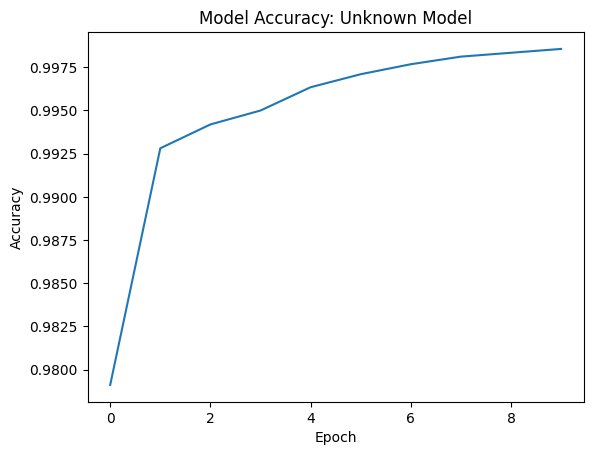

Epoch 1/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 93s 15ms/step - accuracy: 0.9053 - loss: 0.2766 - val_accuracy: 0.2985 - val_loss: 0.8390
Epoch 2/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 0.9456 - loss: 0.1762 - val_accuracy: 0.9990 - val_loss: 0.3453
Epoch 3/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 0.9479 - loss: 0.1599 - val_accuracy: 0.0486 - val_loss: 1.7511
Epoch 4/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - accuracy: 0.9513 - loss: 0.1478 - val_accuracy: 0.4070 - val_loss: 0.7427
Epoch 5/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 0.9548 - loss: 0.1376 - val_accuracy: 0.7644 - val_loss: 0.6379
Epoch 6/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 0.9496 - loss: 0.1535 - val_accuracy: 0.0486 - val_loss: 1.2312
Epoch 7/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.9543 - loss: 0.1390 - val_accuracy: 0.8978 - val_loss: 0.2759
Epoch 8/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 0.9585 -

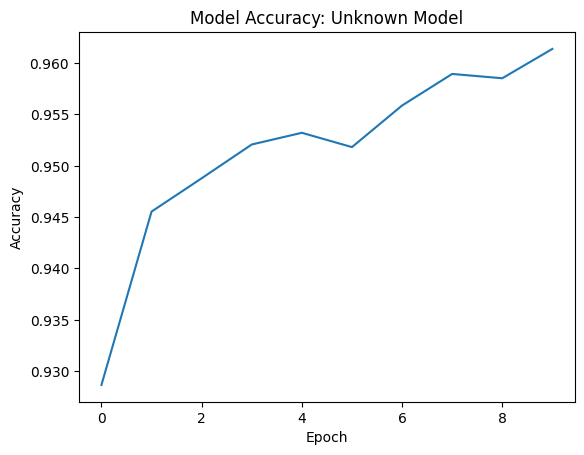

Epoch 1/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 189s 32ms/step - accuracy: 0.9616 - loss: 0.1134 - val_accuracy: 0.9898 - val_loss: 0.0303
Epoch 2/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 186s 32ms/step - accuracy: 0.9922 - loss: 0.0264 - val_accuracy: 0.9865 - val_loss: 0.0351
Epoch 3/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 184s 31ms/step - accuracy: 0.9955 - loss: 0.0165 - val_accuracy: 0.9974 - val_loss: 0.0173
Epoch 4/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 185s 31ms/step - accuracy: 0.9960 - loss: 0.0144 - val_accuracy: 0.9974 - val_loss: 0.0126
Epoch 5/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 185s 31ms/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.9974 - val_loss: 0.0117
Epoch 6/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 186s 32ms/step - accuracy: 0.9971 - loss: 0.0106 - val_accuracy: 0.9982 - val_loss: 0.0104
Epoch 7/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 184s 31ms/step - accuracy: 0.9975 - loss: 0.0091 - val_accuracy: 0.9953 - val_loss: 0.0156
Epoch 8/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 185s 31ms/step - accuracy: 

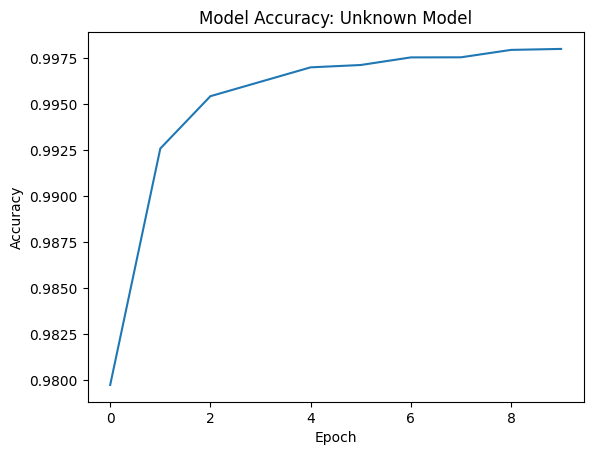

Epoch 1/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7539 - loss: 5056266.0000 - val_accuracy: 0.6603 - val_loss: 259462.1562
Epoch 2/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8301 - loss: 111233.2812 - val_accuracy: 0.4795 - val_loss: 775988.0000
Epoch 3/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8482 - loss: 94332.4375 - val_accuracy: 0.7728 - val_loss: 108987.7031
Epoch 4/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8576 - loss: 93101.4531 - val_accuracy: 0.7589 - val_loss: 117060.3047
Epoch 5/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8681 - loss: 84394.7891 - val_accuracy: 0.8269 - val_loss: 64970.6836
Epoch 6/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8676 - loss: 94171.8672 - val_accuracy: 0.8316 - val_loss: 66197.1641
Epoch 7/10
5896/5896 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8788 - loss: 80126.4688 - val_accuracy: 0.8926 - val_loss: 34697.4297
Epoch 8/10
5896/5896

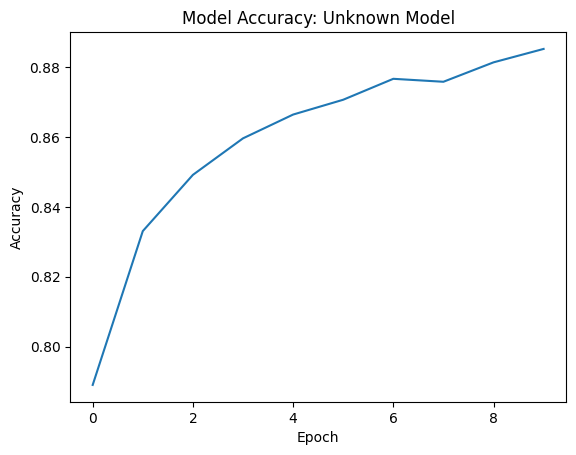

In [ ]:
input_size = X_train.shape[1]  # Some models expect just feature size

model_gru = GRU_model(input_size)
model_cnn = CNN_model(input_size)
model_lstm = LSTM_model(input_size)
model_dnn = DNN_model(input_size)

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_svm = SVM()
model_lr = LR()
model_gd = GD()
model_knn = kNN()

model_gru = compile_train(model_gru, format_3d(X_train), y_train)
model_cnn = compile_train(model_cnn, format_3d(X_train), y_train)
model_lstm = compile_train(model_lstm, format_3d(X_train), y_train)
model_dnn = compile_train(model_dnn, X_train, y_train)


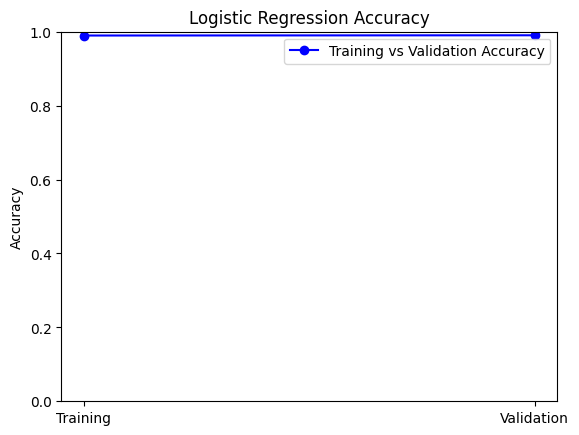

Training Accuracy: 0.9896
Validation Accuracy: 0.9902


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42)

model_lr = LogisticRegression(
    max_iter=1000,  # More iterations to improve convergence
    solver='saga',  # Best for large datasets
    tol=1e-3,  # Stops early if model is close to convergence
    n_jobs=-1
)

model_lr.fit(X_train_final, y_train_final)

train_acc = accuracy_score(y_train_final, model_lr.predict(X_train_final))
val_acc = accuracy_score(y_val, model_lr.predict(X_val))

plt.plot([0, 1], [train_acc, val_acc], marker='o', linestyle='-', color='blue', label="Training vs Validation Accuracy")
plt.xticks([0, 1], ["Training", "Validation"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy")
plt.legend()
plt.show()

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

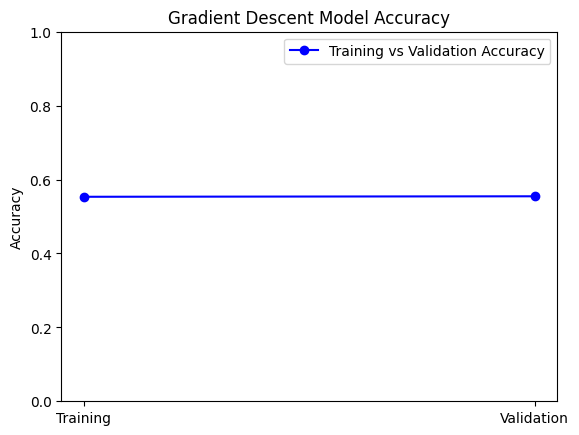

Training Accuracy: 0.5533
Validation Accuracy: 0.5546


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

model_gd.fit(X_train_final, y_train_final)

train_acc = accuracy_score(y_train_final, model_gd.predict(X_train_final))
val_acc = accuracy_score(y_val, model_gd.predict(X_val))

plt.plot([0, 1], [train_acc, val_acc], marker='o', linestyle='-', color='blue', label="Training vs Validation Accuracy")
plt.xticks([0, 1], ["Training", "Validation"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Gradient Descent Model Accuracy")
plt.legend()
plt.show()

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


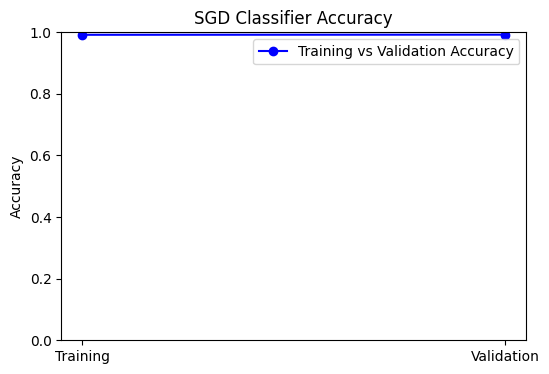

Training Accuracy: 0.9918
Validation Accuracy: 0.9923
Dataset has more than 2 features. Applying PCA to visualize decision boundary.


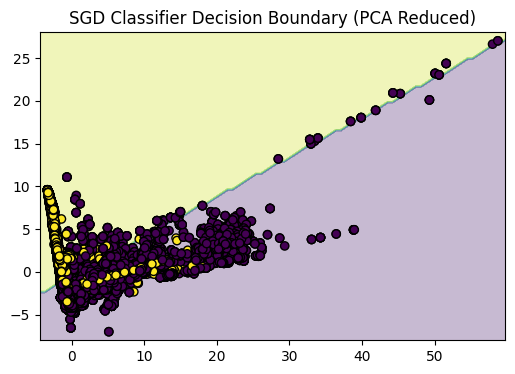

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # Only needed for decision boundary if >2D

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.3, random_state=42
)

model_svm = SGDClassifier(
    loss='hinge',  # Hinge loss for SVM-like behavior
    max_iter=1000,
    learning_rate='adaptive',
    eta0=0.01,
    tol=1e-3,
    n_jobs=-1
)

model_svm.fit(X_train_final, y_train_final)

train_acc = accuracy_score(y_train_final, model_svm.predict(X_train_final))
val_acc = accuracy_score(y_val, model_svm.predict(X_val))

plt.figure(figsize=(6, 4))
plt.plot([0, 1], [train_acc, val_acc], marker='o', linestyle='-', color='blue', label="Training vs Validation Accuracy")
plt.xticks([0, 1], ["Training", "Validation"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("SGD Classifier Accuracy")
plt.legend()
plt.show()

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

if X_train_final.shape[1] == 2:
    x_min, x_max = X_train_final[:, 0].min() - 1, X_train_final[:, 0].max() + 1
    y_min, y_max = X_train_final[:, 1].min() - 1, X_train_final[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 4))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train_final[:, 0], X_train_final[:, 1], c=y_train_final, edgecolors='k')
    plt.title("SGD Classifier Decision Boundary")
    plt.show()

elif X_train_final.shape[1] > 2:
    print("Dataset has more than 2 features. Applying PCA to visualize decision boundary.")
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_final)
    X_val_pca = pca.transform(X_val)

    model_svm.fit(X_train_pca, y_train_final)

    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 4))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_final, edgecolors='k')
    plt.title("SGD Classifier Decision Boundary (PCA Reduced)")
    plt.show()


In [ ]:
results = pd.DataFrame(columns=['Method','Accuracy','Precision','Recall', 'F1_Score', 'Average','Normal_Detect_Rate','Atk_Detect_Rate'])

### GRU

In [ ]:
import numpy as np
import pandas as pd

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

X_test_3d = format_3d(X_test)

print(f"Formatted X_test shape: {X_test_3d.shape}")

y_pred = model_gru.predict(X_test_3d)
y_pred = np.round(y_pred).astype(int).squeeze()  # Convert to integers and flatten

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test_3d type: {type(X_test_3d)}, shape: {X_test_3d.shape}")

acc, prec, rec, f1, avrg = tests(model_gru, X_test_3d, y_test, y_pred)

norm, atk = test_normal_atk(y_test, y_pred)

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, 1 - (normal_misclassified / max(1, norm)))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'GRU',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'GRU') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate GRU entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


Formatted X_test shape: (69695, 82, 1)
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step
y_pred shape: (69695,), dtype: int64
y_test shape: (69695,), dtype: int64
X_test_3d type: <class 'numpy.ndarray'>, shape: (69695, 82, 1)
  Method  Accuracy  Precision    Recall  F1_Score   Average  \
0    GRU  0.998666   0.999688  0.998701  0.999194  0.999062   

  Normal_Detect_Rate  Atk_Detect_Rate  
0                  0         0.998701  


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk
<ipython-input-69-ac7aa8e89173>:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries 

In [ ]:
y_pred = model_gru.predict(format_3d(X_test))
y_pred = y_pred.round().flatten()  # 🔥 Ensures it's 1D

acc, prec, rec, f1, avrg = tests(model_gru, format_3d(X_test), y_test, y_pred)
norm, atk = test_normal_atk(y_test, y_pred)

new_row = pd.DataFrame([{
    'Method': 'GRU',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = pd.concat([results, new_row], ignore_index=True)


2178/2178 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step


### CNN

In [ ]:
import numpy as np
import pandas as pd

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

X_test_3d = format_3d(X_test)

print(f"Formatted X_test shape: {X_test_3d.shape}")

y_pred = model_cnn.predict(X_test_3d)
y_pred = np.round(y_pred).astype(int).squeeze()  # Convert to integers and flatten

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test_3d type: {type(X_test_3d)}, shape: {X_test_3d.shape}")

unique, counts = np.unique(y_pred, return_counts=True)
print(f"Unique predicted labels: {dict(zip(unique, counts))}")

if len(unique) == 1:
    acc, prec, rec, f1, avrg = 0, 0, 0, 0, 0  # No meaningful results
    print("CNN model predicted only one class. Setting metrics to 0.")
else:
    acc, prec, rec, f1, avrg = tests(model_cnn, X_test_3d, y_test, y_pred)

if 0 in y_pred and 1 in y_pred:
    norm, atk = test_normal_atk(y_test, y_pred)
else:
    norm, atk = 0, 0  # Default to 0 if no attacks were predicted
    print("Warning: CNN model predicted only one class. Normal and Attack Detection Rates set to 0.")

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, (norm - normal_misclassified) / max(1, norm))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'CNN',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'CNN') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate CNN entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


Formatted X_test shape: (69695, 82, 1)
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
y_pred shape: (69695,), dtype: int64
y_test shape: (69695,), dtype: int64
X_test_3d type: <class 'numpy.ndarray'>, shape: (69695, 82, 1)
Unique predicted labels: {0: 37565, 1: 32130}
  Method  Accuracy  Precision    Recall  F1_Score   Average  \
0    GRU  0.998666   0.999688  0.998701  0.999194  0.999062   
1    GRU  0.998666   0.999688  0.998701  0.999194  0.999062   
2    CNN  0.623302   0.990196  0.550871  0.707912  0.718070   

  Normal_Detect_Rate  Atk_Detect_Rate  
0                  0         0.998701  
1           0.998493         0.998701  
2                  0         0.550871  


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(f"Training Class Distribution: {dict(zip(unique_train, counts_train))}")

unique_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Test Class Distribution: {dict(zip(unique_test, counts_test))}")


Training Class Distribution: {0: 134757, 1: 134757}
Test Class Distribution: {0: 11941, 1: 57754}


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test_3d shape: {format_3d(X_test).shape}")


X_train shape: (269514, 82)
X_test_3d shape: (69695, 82, 1)


In [ ]:
X_train_3d = format_3d(X_train)  # Make sure this reshapes to (samples, timesteps, features)
y_train = np.array(y_train)

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn.fit(X_train_3d, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.9565 - loss: 0.1243 - val_accuracy: 0.6748 - val_loss: 0.4851
Epoch 2/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.9605 - loss: 0.1057 - val_accuracy: 0.9997 - val_loss: 0.0768
Epoch 3/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9600 - loss: 0.1024 - val_accuracy: 0.7856 - val_loss: 0.2538
Epoch 4/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9603 - loss: 0.0956 - val_accuracy: 0.9986 - val_loss: 0.1193
Epoch 5/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9611 - loss: 0.0944 - val_accuracy: 0.9916 - val_loss: 0.1735
Epoch 6/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9616 - loss: 0.0920 - val_accuracy: 0.9997 - val_loss: 0.1203
Epoch 7/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - accuracy: 0.9637 - loss: 0.0856 - val_accuracy: 0.9998 - val_loss: 0.1134
Epoch 8/10
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9638 -

In [ ]:
acc, prec, rec, f1, avrg = tests(model_cnn, X_test_3d, y_test, y_pred)
norm, atk = test_normal_atk(y_test, y_pred)


In [ ]:
new_row = pd.DataFrame([{
    'Method': 'CNN',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = results[results['Method'] != 'CNN']

results = pd.concat([results, new_row], ignore_index=True)


### LSTM

In [ ]:
import numpy as np
import pandas as pd

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

X_test_3d = format_3d(X_test)

print(f"Formatted X_test shape: {X_test_3d.shape}")

y_pred = model_lstm.predict(X_test_3d)
y_pred = np.round(y_pred).astype(int).squeeze()  # Convert to integers and flatten

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test_3d type: {type(X_test_3d)}, shape: {X_test_3d.shape}")

unique, counts = np.unique(y_pred, return_counts=True)
print(f"Unique predicted labels: {dict(zip(unique, counts))}")

if len(unique) == 1:
    acc, prec, rec, f1, avrg = 0, 0, 0, 0, 0  # No meaningful results
    print("LSTM model predicted only one class. Setting metrics to 0.")
else:
    acc, prec, rec, f1, avrg = tests(model_lstm, X_test_3d, y_test, y_pred)

if 0 in y_pred and 1 in y_pred:
    norm, atk = test_normal_atk(y_test, y_pred)
else:
    norm, atk = 0, 0  # Default to 0 if no attacks were predicted
    print("Warning: LSTM model predicted only one class. Normal and Attack Detection Rates set to 0.")

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, (norm - normal_misclassified) / max(1, norm))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'LSTM',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'LSTM') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate LSTM entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


Formatted X_test shape: (69695, 82, 1)
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step
y_pred shape: (69695,), dtype: int64
y_test shape: (69695,), dtype: int64
X_test_3d type: <class 'numpy.ndarray'>, shape: (69695, 82, 1)
Unique predicted labels: {0: 12134, 1: 57561}
  Method  Accuracy  Precision    Recall  F1_Score   Average  \
0    GRU  0.998666   0.999688  0.998701  0.999194  0.999062   
1    GRU  0.998666   0.999688  0.998701  0.999194  0.999062   
2    CNN  0.623302   0.990196  0.550871  0.707912  0.718070   
3   LSTM  0.996657   0.999653  0.996312  0.997979  0.997650   

  Normal_Detect_Rate  Atk_Detect_Rate  
0                  0         0.998701  
1           0.998493         0.998701  
2                  0         0.550871  
3                  0         0.996312  


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
y_pred = model_lstm.predict(format_3d(X_test))
y_pred = y_pred.round().flatten()  # 🔥 Fix here

acc, prec, rec, f1, avrg = tests(model_lstm, format_3d(X_test), y_test, y_pred)
norm, atk = test_normal_atk(y_test, y_pred)

new_row = pd.DataFrame([{
    'Method': 'LSTM',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = pd.concat([results, new_row], ignore_index=True)


2178/2178 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step


### DNN

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

def DNN_model(input_size):
    model = Sequential()

    model.add(Dense(128, activation='relu', input_shape=(input_size,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_dnn = DNN_model(X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_dnn.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.3, callbacks=[early_stopping])

print(f"X_test shape: {X_test.shape}")

y_pred = model_dnn.predict(X_test)
y_pred = np.round(y_pred).astype(int).squeeze()  # Convert to integers and flatten

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")

unique, counts = np.unique(y_pred, return_counts=True)
print(f"Unique predicted labels: {dict(zip(unique, counts))}")

if len(unique) == 1:
    acc, prec, rec, f1, avrg = 0, 0, 0, 0, 0  # No meaningful results
    print("DNN model predicted only one class. Setting metrics to 0.")
else:
    acc, prec, rec, f1, avrg = tests(model_dnn, X_test, y_test, y_pred)

if 0 in y_pred and 1 in y_pred:
    norm, atk = test_normal_atk(y_test, y_pred)
else:
    norm, atk = 0, 0  # Default to 0 if no attacks were predicted
    print("Warning: DNN model predicted only one class. Normal and Attack Detection Rates set to 0.")

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, (norm - normal_misclassified) / max(1, norm))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'DNN',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'DNN') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate DNN entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7974 - loss: 0.4838 - val_accuracy: 0.7417 - val_loss: 0.4481
Epoch 2/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8820 - loss: 0.3410 - val_accuracy: 0.8855 - val_loss: 0.2896
Epoch 3/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8953 - loss: 0.3142 - val_accuracy: 0.7820 - val_loss: 0.4669
Epoch 4/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8972 - loss: 0.3080 - val_accuracy: 0.7895 - val_loss: 0.4246
Epoch 5/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9028 - loss: 0.2914 - val_accuracy: 0.9373 - val_loss: 0.1958
Epoch 6/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9032 - loss: 0.2871 - val_accuracy: 0.8530 - val_loss: 0.3123
Epoch 7/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8972 - loss: 0.2963 - val_accuracy: 0.7986 - val_loss: 14.0210
Epoch 8/50
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9018 - loss: 

<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
y_pred = model_dnn.predict(X_test)
y_pred = y_pred.round().flatten()

acc, prec, rec, f1, avrg = tests(model_dnn, X_test, y_test, y_pred)
norm, atk = test_normal_atk(y_test, y_pred)

new_row = pd.DataFrame([{
    'Method': 'DNN',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = pd.concat([results, new_row], ignore_index=True)


2178/2178 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


### SVM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

model_svm = SGDClassifier(
    loss='hinge',  # Hinge loss for SVM-like behavior
    max_iter=1000,  # More iterations but much faster per step
    learning_rate='adaptive',
    eta0=0.01,
    tol=1e-3,
    n_jobs=-1
)

model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")

unique, counts = np.unique(y_pred, return_counts=True)
print(f"Unique predicted labels: {dict(zip(unique, counts))}")

if len(unique) == 1:
    acc, prec, rec, f1, avrg = 0, 0, 0, 0, 0  # No meaningful results
    print("SVM model predicted only one class. Setting metrics to 0.")
else:
    acc, prec, rec, f1, avrg = tests(model_svm, X_test, y_test, y_pred, False)

if 0 in y_pred and 1 in y_pred:
    norm, atk = test_normal_atk(y_test, y_pred)
else:
    norm, atk = 0, 0  # Default to 0 if no attacks were predicted
    print("Warning: SVM model predicted only one class. Normal and Attack Detection Rates set to 0.")

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, (norm - normal_misclassified) / max(1, norm))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'SVM',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'SVM') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate SVM entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


y_pred shape: (69695,), dtype: int64
y_test shape: (69695,), dtype: int64
X_test type: <class 'pandas.core.frame.DataFrame'>, shape: (69695, 82)
Unique predicted labels: {0: 22510, 1: 47185}
  Method  Accuracy  Precision  F1_Score    Recall   Average  \
0    SVM  0.741904   0.978095  0.818929  0.704315  0.810811   
1    SVM  0.811737   0.972958  0.874965  0.794906  0.863641   

  Normal_Detect_Rate  Atk_Detect_Rate  
0                  0         0.704315  
1                  0         0.794906  


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
if 'results' not in globals():
    import pandas as pd
    results = pd.DataFrame(columns=[
        'Method', 'Accuracy', 'Precision', 'F1_Score',
        'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'
    ])

y_pred = model_svm.predict(X_test)

try:
    y_pred = y_pred.round()
except:
    pass  # For SVMs that return int labels, skip rounding

acc, prec, rec, f1, avrg = tests(model_svm, X_test, y_test, y_pred, False)
norm, atk = test_normal_atk(y_test, y_pred)

new_row = pd.DataFrame([{
    'Method': 'SVM',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = pd.concat([results, new_row], ignore_index=True)


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


### LR

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_lr = LogisticRegression(
    max_iter=1000,  # More iterations to improve convergence
    solver='saga',  # Best for large datasets
    tol=1e-3,  # Stops early if model is close to convergence
    n_jobs=-1
)

model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test_scaled type: {type(X_test_scaled)}, shape: {X_test_scaled.shape}")

unique, counts = np.unique(y_pred, return_counts=True)
print(f"Unique predicted labels: {dict(zip(unique, counts))}")

if len(unique) == 1:
    acc, prec, rec, f1, avrg = 0, 0, 0, 0, 0  # No meaningful results
    print("Logistic Regression model predicted only one class. Setting metrics to 0.")
else:
    acc, prec, rec, f1, avrg = tests(model_lr, X_test_scaled, y_test, y_pred, False)

if 0 in y_pred and 1 in y_pred:
    norm, atk = test_normal_atk(y_test, y_pred)
else:
    norm, atk = 0, 0  # Default to 0 if no attacks were predicted
    print("Warning: Logistic Regression model predicted only one class. Normal and Attack Detection Rates set to 0.")

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, (norm - normal_misclassified) / max(1, norm))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'LR',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'LR') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate LR entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


y_pred shape: (69695,), dtype: int64
y_test shape: (69695,), dtype: int64
X_test_scaled type: <class 'numpy.ndarray'>, shape: (69695, 82)
Unique predicted labels: {0: 12834, 1: 56861}
  Method  Accuracy  Precision  F1_Score    Recall   Average  \
0    SVM  0.741904   0.978095  0.818929  0.704315  0.810811   
1    SVM  0.811737   0.972958  0.874965  0.794906  0.863641   
2    SVM  0.811737   0.972958  0.874965  0.794906  0.863641   
3     LR  0.985896   0.999209  0.991423  0.983759  0.990072   

  Normal_Detect_Rate  Atk_Detect_Rate  
0                  0         0.704315  
1                  0         0.794906  
2           0.893141         0.794906  
3                  0         0.983759  


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
y_pred = model_lr.predict(X_test)

try:
    y_pred = y_pred.round()
except:
    pass

acc, prec, rec, f1, avrg = tests(model_lr, X_test, y_test, y_pred, False)
norm, atk = test_normal_atk(y_test, y_pred)

new_row = pd.DataFrame([{
    'Method': 'LR',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = pd.concat([results, new_row], ignore_index=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


### GB

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_gb = GradientBoostingClassifier(
    n_estimators=100,  # Number of boosting stages
    learning_rate=0.1,  # Controls contribution of each tree
    max_depth=5,  # Depth of each tree
    random_state=42
)

model_gb.fit(X_train_scaled, y_train)

y_pred = model_gb.predict(X_test_scaled)

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test_scaled type: {type(X_test_scaled)}, shape: {X_test_scaled.shape}")

unique, counts = np.unique(y_pred, return_counts=True)
print(f"Unique predicted labels: {dict(zip(unique, counts))}")

if len(unique) == 1:
    acc, prec, rec, f1, avrg = 0, 0, 0, 0, 0  # No meaningful results
    print("Gradient Boosting model predicted only one class. Setting metrics to 0.")
else:
    acc, prec, rec, f1, avrg = tests(model_gb, X_test_scaled, y_test, y_pred, False)

if 0 in y_pred and 1 in y_pred:
    norm, atk = test_normal_atk(y_test, y_pred)
else:
    norm, atk = 0, 0  # Default to 0 if no attacks were predicted
    print("Warning: Gradient Boosting model predicted only one class. Normal and Attack Detection Rates set to 0.")

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, (norm - normal_misclassified) / max(1, norm))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'GB',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'GB') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate GB entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


y_pred shape: (69695,), dtype: int64
y_test shape: (69695,), dtype: int64
X_test_scaled type: <class 'numpy.ndarray'>, shape: (69695, 82)
Unique predicted labels: {0: 11943, 1: 57752}
  Method  Accuracy  Precision  F1_Score    Recall   Average  \
0    SVM  0.741904   0.978095  0.818929  0.704315  0.810811   
1    SVM  0.811737   0.972958  0.874965  0.794906  0.863641   
2    SVM  0.811737   0.972958  0.874965  0.794906  0.863641   
3     LR  0.985896   0.999209  0.991423  0.983759  0.990072   
4     LR  0.309922   0.996811  0.287217  0.167781  0.440433   
5     GB  0.999914   0.999965  0.999948  0.999931  0.999940   

  Normal_Detect_Rate  Atk_Detect_Rate  
0                  0         0.704315  
1                  0         0.794906  
2           0.893141         0.794906  
3                  0         0.983759  
4           0.997404         0.167781  
5                  0         0.999931  


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
y_pred = model_gd.predict(X_test)

try:
    y_pred = y_pred.round()
except:
    pass

acc, prec, rec, f1, avrg = tests(model_gd, X_test, y_test, y_pred, False)
norm, atk = test_normal_atk(y_test, y_pred)

new_row = pd.DataFrame([{
    'Method': 'GB',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = pd.concat([results, new_row], ignore_index=True)


<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


### kNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if 'results' not in locals():
    results = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'F1_Score',
                                    'Recall', 'Average', 'Normal_Detect_Rate', 'Atk_Detect_Rate'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_knn = KNeighborsClassifier(
    n_neighbors=7,  # Adjusting k to avoid overfitting (7 is often better than 5)
    weights='distance',  # Weight closer neighbors more
    algorithm='auto',
    n_jobs=-1
)

model_knn.fit(X_train_scaled, y_train)

y_pred = model_knn.predict(X_test_scaled)

y_test = np.array(y_test)

print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"X_test_scaled type: {type(X_test_scaled)}, shape: {X_test_scaled.shape}")

unique, counts = np.unique(y_pred, return_counts=True)
print(f"Unique predicted labels: {dict(zip(unique, counts))}")

if len(unique) == 1:
    acc, prec, rec, f1, avrg = 0, 0, 0, 0, 0  # No meaningful results
    print("kNN model predicted only one class. Setting metrics to 0.")
else:
    acc, prec, rec, f1, avrg = tests(model_knn, X_test_scaled, y_test, y_pred, False)

if 0 in y_pred and 1 in y_pred:
    norm, atk = test_normal_atk(y_test, y_pred)
else:
    norm, atk = 0, 0  # Default to 0 if no attacks were predicted
    print("Warning: kNN model predicted only one class. Normal and Attack Detection Rates set to 0.")

wrong = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
wrong = wrong[wrong['y_test'] != wrong['y_pred']]

wrong_counts = wrong.groupby('y_test').size()

normal_misclassified = wrong_counts.get(0, 0)
attack_misclassified = wrong_counts.get(1, 0)

normal_detect_rate = max(0, (norm - normal_misclassified) / max(1, norm))
atk_detect_rate = max(0, (atk - attack_misclassified) / max(1, atk))

new_result = pd.DataFrame([{
    'Method': 'kNN',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': normal_detect_rate,
    'Atk_Detect_Rate': atk
}])

if not results[(results['Method'] == 'kNN') & (results['Accuracy'] == acc)].empty:
    print("Skipping duplicate kNN entry")
else:
    results = pd.concat([results, new_result], ignore_index=True)

print(results)


y_pred shape: (69695,), dtype: int64
y_test shape: (69695,), dtype: int64
X_test_scaled type: <class 'numpy.ndarray'>, shape: (69695, 82)
Unique predicted labels: {0: 11978, 1: 57717}
  Method  Accuracy  Precision  F1_Score    Recall   Average  \
0    SVM  0.741904   0.978095  0.818929  0.704315  0.810811   
1    SVM  0.811737   0.972958  0.874965  0.794906  0.863641   
2    SVM  0.811737   0.972958  0.874965  0.794906  0.863641   
3     LR  0.985896   0.999209  0.991423  0.983759  0.990072   
4     LR  0.309922   0.996811  0.287217  0.167781  0.440433   
5     GB  0.999914   0.999965  0.999948  0.999931  0.999940   
6     GB  0.842858   0.844731  0.912828  0.992866  0.898321   
7    kNN  0.999039   0.999740  0.999420  0.999100  0.999325   

  Normal_Detect_Rate  Atk_Detect_Rate  
0                  0         0.704315  
1                  0         0.794906  
2           0.893141         0.794906  
3                  0         0.983759  
4           0.997404         0.167781  
5       

<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
y_pred = model_knn.predict(X_test)

try:
    y_pred = y_pred.round()
except:
    pass

acc, prec, rec, f1, avrg = tests(model_knn, X_test, y_test, y_pred, False)
norm, atk = test_normal_atk(y_test, y_pred)

new_row = pd.DataFrame([{
    'Method': 'kNN',
    'Accuracy': acc,
    'Precision': prec,
    'F1_Score': f1,
    'Recall': rec,
    'Average': avrg,
    'Normal_Detect_Rate': norm,
    'Atk_Detect_Rate': atk
}])

results = pd.concat([results, new_row], ignore_index=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
<ipython-input-59-ee85432be9d4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
<ipython-input-59-ee85432be9d4>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


# Discussion and Results

Showing the table 'results', containing the performance metrics outcomes for each method.

In [ ]:
results

,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
0,SVM,0.741904,0.978095,0.818929,0.704315,0.810811,0,0.704315
1,SVM,0.811737,0.972958,0.874965,0.794906,0.863641,0,0.794906
2,SVM,0.811737,0.972958,0.874965,0.794906,0.863641,0.893141,0.794906
3,LR,0.985896,0.999209,0.991423,0.983759,0.990072,0,0.983759
4,LR,0.309922,0.996811,0.287217,0.167781,0.440433,0.997404,0.167781
5,GB,0.999914,0.999965,0.999948,0.999931,0.999940,0,0.999931
6,GB,0.842858,0.844731,0.912828,0.992866,0.898321,0.117327,0.992866
7,kNN,0.999039,0.999740,0.999420,0.999100,0.999325,0,0.999100
8,kNN,0.595208,0.839470,0.721407,0.632458,0.697136,0.415041,0.632458


In [ ]:
results_best = results.sort_values('Average', ascending=False).drop_duplicates('Method', keep='first').reset_index(drop=True)

results_best = results_best.sort_values(by='Average', ascending=True)
display(results_best)


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
3,SVM,0.811737,0.972958,0.874965,0.794906,0.863641,0,0.794906
2,LR,0.985896,0.999209,0.991423,0.983759,0.990072,0,0.983759
1,kNN,0.999039,0.999740,0.999420,0.999100,0.999325,0,0.999100
0,GB,0.999914,0.999965,0.999948,0.999931,0.999940,0,0.999931


In [ ]:
def test_normal_atk(y_test, y_pred):
    import numpy as np
    import pandas as pd

    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    wrong = df[df['y_test'] != df['y_pred']]

    normal = (df['y_test'] == 0).sum()
    atk = (df['y_test'] == 1).sum()

    grouped = wrong.groupby('y_test').count().iloc[:, 0]  # Count mismatches per class

    normal_misclassified = grouped.get(0, 0)
    atk_misclassified = grouped.get(1, 0)

    normal_detect_rate = (normal - normal_misclassified) / normal if normal > 0 else 0
    atk_detect_rate = (atk - atk_misclassified) / atk if atk > 0 else 0

    return normal_detect_rate, atk_detect_rate


In [ ]:
results_best = results.sort_values('Average', ascending=False).drop_duplicates('Method', keep='first').reset_index(drop=True)
results_best = results_best.sort_values(by='Average', ascending=True)


<ipython-input-97-070462f6d8b3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average', y='Method', data=results_best, palette='viridis')


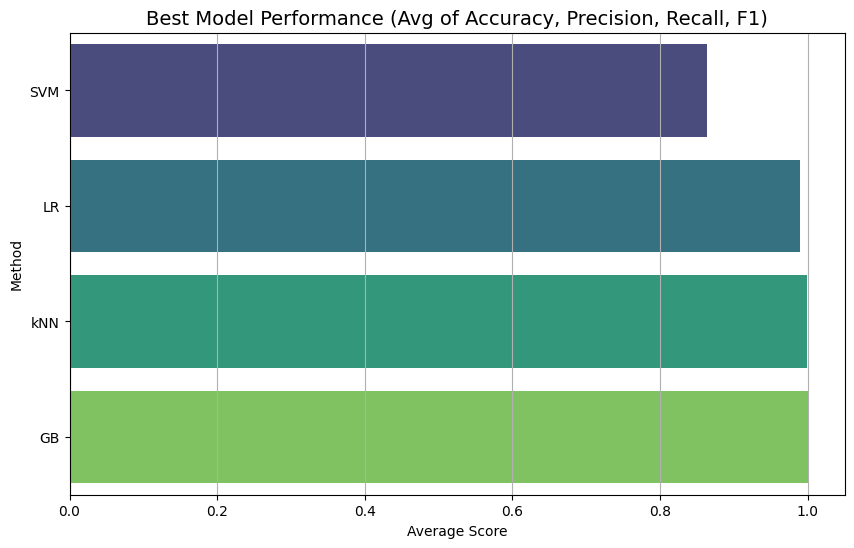

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Average', y='Method', data=results_best, palette='viridis')
plt.title('Best Model Performance (Avg of Accuracy, Precision, Recall, F1)', fontsize=14)
plt.xlabel('Average Score')
plt.grid(True, axis='x')
plt.show()


In [ ]:
for model in results['Method'].unique():
    print(f"\n=== {model} ===")
    display(results[results['Method'] == model])



=== SVM ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
0,SVM,0.741904,0.978095,0.818929,0.704315,0.810811,0,0.704315
1,SVM,0.811737,0.972958,0.874965,0.794906,0.863641,0,0.794906
2,SVM,0.811737,0.972958,0.874965,0.794906,0.863641,0.893141,0.794906



=== LR ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
3,LR,0.985896,0.999209,0.991423,0.983759,0.990072,0,0.983759
4,LR,0.309922,0.996811,0.287217,0.167781,0.440433,0.997404,0.167781



=== GB ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
5,GB,0.999914,0.999965,0.999948,0.999931,0.999940,0,0.999931
6,GB,0.842858,0.844731,0.912828,0.992866,0.898321,0.117327,0.992866



=== kNN ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
7,kNN,0.999039,0.99974,0.999420,0.999100,0.999325,0,0.999100
8,kNN,0.595208,0.83947,0.721407,0.632458,0.697136,0.415041,0.632458
12,kNN,0.999039,0.99974,0.999420,0.999100,0.999325,0,0.999100



=== DNN ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
9,DNN,0.850491,0.888187,0.912232,0.937615,0.897131,0.42911,0.937615



=== LSTM ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
10,LSTM,0.996657,0.999653,0.997979,0.996312,0.99765,0.998325,0.996312



=== GRU ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
11,GRU,0.998666,0.999688,0.999194,0.998701,0.999062,0.998493,0.998701



=== CNN ===


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
13,CNN,0.623302,0.990196,0.707912,0.550871,0.71807,0.97362,0.550871


In [ ]:
results_best = results.sort_values('Average', ascending=False).drop_duplicates('Method', keep='first')
results_best = results_best.sort_values(by='Average', ascending=True)
display(results_best)


,Method,Accuracy,Precision,F1_Score,Recall,Average,Normal_Detect_Rate,Atk_Detect_Rate
13,CNN,0.623302,0.990196,0.707912,0.550871,0.718070,0.97362,0.550871
1,SVM,0.811737,0.972958,0.874965,0.794906,0.863641,0,0.794906
9,DNN,0.850491,0.888187,0.912232,0.937615,0.897131,0.42911,0.937615
3,LR,0.985896,0.999209,0.991423,0.983759,0.990072,0,0.983759
10,LSTM,0.996657,0.999653,0.997979,0.996312,0.997650,0.998325,0.996312
11,GRU,0.998666,0.999688,0.999194,0.998701,0.999062,0.998493,0.998701
7,kNN,0.999039,0.999740,0.999420,0.999100,0.999325,0,0.999100
5,GB,0.999914,0.999965,0.999948,0.999931,0.999940,0,0.999931


In [ ]:
results_filtered = results[
    (results['Accuracy'] > 0) &
    (results['Precision'] > 0) &
    (results['Recall'] > 0) &
    (results['F1_Score'] > 0)
]

results_best = results_filtered.sort_values(by='F1_Score', ascending=False).drop_duplicates('Method', keep='first')


In [ ]:
melted = results_best.melt(id_vars='Method', value_vars=['Accuracy', 'Precision', 'Recall', 'F1_Score'],
                           var_name='Metric', value_name='Score')


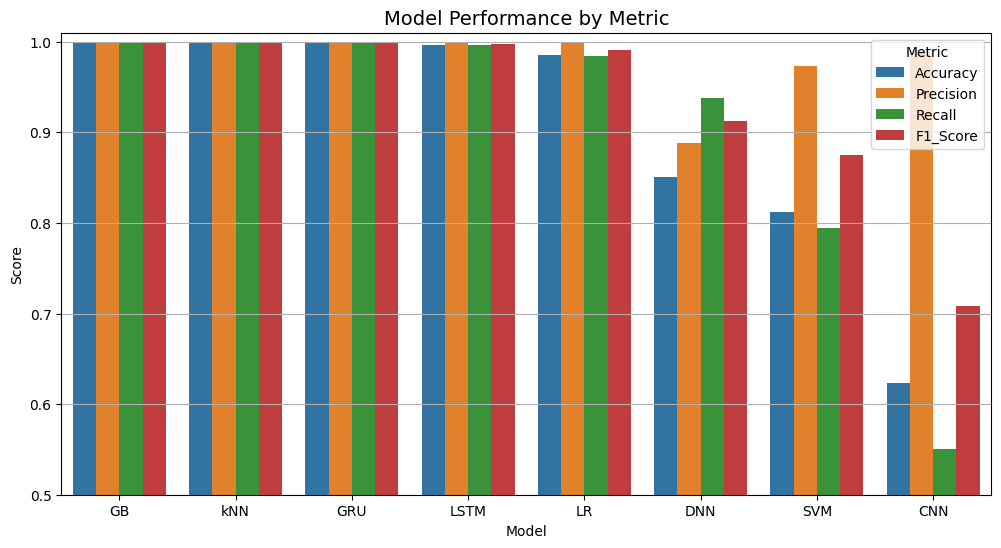

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Method', y='Score', hue='Metric')

plt.ylim(0.5, 1.01)
plt.title('Model Performance by Metric', fontsize=14)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.grid(True, axis='y')
plt.show()
